In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# загружаем данные из csv файла
df = pd.read_csv(r"C:\Users\Admin\Jupyter\zakupki\dataset_nlp_process.csv",  on_bad_lines='skip', low_memory=False, sep=';') 
df['subject']  = df['subject'].astype('string')
df['cost']  = df['cost'].astype('int64')
df['okpd_code']  = df['okpd_code'].astype('string')
df['okpd_code']  = df['okpd_code'].apply(lambda x: x.strip())
df['price_per_day'] = (df['cost'] / df['execution_period']).astype('int64')
df.dtypes

id                           int64
subject             string[python]
okpd_code                   object
cost                         int64
execution_period             int64
data                        object
data_final                  object
price_per_day                int64
dtype: object

In [5]:
df = df.drop('data', axis=1)

In [6]:
df.head(4)

,id,subject,okpd_code,cost,execution_period,data_final,price_per_day
0,27206446,"приобретение нежилого здания, в целях осуществ...",41.2,18061000,1,"['приобретен', 'нежил', 'здан', 'цел', 'осущес...",18061000
1,18675346,Выполнение работ по ремонту подъездов по адрес...,41.2,1740653,1,"['выполнен', 'работ', 'ремонт', 'подъезд', 'ад...",1740653
2,22454818,Содержание автомобильных дорог местного значен...,42.1,35528286,1,"['содержан', 'автомобильн', 'дорог', 'местн', ...",35528286
3,21437940,"Ремонт автомобильной дороги,ул.2-я Пятилетка (...",42.1,976423,1,"['ремонт', 'автомобильн', 'дорог', 'пятилетк',...",976423


In [7]:
#Делаем разбивку по группам на основании номеров ОКПД-2
import re 

def match(templ, value):
    try:
      return re.search(f'^{templ}.', value) 
    except Exception as e:
        print(f"{type(e).__name__}: {e}")
        return False
    
def get_group(value):    
    if (match('41', value) or match('42', value) or match('43', value)) and  value not in ('43.9', '42.9', '42.2', '43.2', '41.1', '71.1', '43.2'):  
        return 'Строительно-монтажные работы'
    elif value in ('41.1', '71.1'):  
        return 'Проектно-изыскательские работы'
    elif value in ('43.2'):  
        return 'Подключение коммуникаций'
    elif value in ('43.9', '42.9', '42.2'):  
        return 'Строительный надзор'
    else:
        return 'Прочие'

df['group'] = df['okpd_code'].apply(lambda x: get_group(x))
df.head()

,id,subject,okpd_code,cost,execution_period,data_final,price_per_day,group
0,27206446,"приобретение нежилого здания, в целях осуществ...",41.2,18061000,1,"['приобретен', 'нежил', 'здан', 'цел', 'осущес...",18061000,Строительно-монтажные работы
1,18675346,Выполнение работ по ремонту подъездов по адрес...,41.2,1740653,1,"['выполнен', 'работ', 'ремонт', 'подъезд', 'ад...",1740653,Строительно-монтажные работы
2,22454818,Содержание автомобильных дорог местного значен...,42.1,35528286,1,"['содержан', 'автомобильн', 'дорог', 'местн', ...",35528286,Строительно-монтажные работы
3,21437940,"Ремонт автомобильной дороги,ул.2-я Пятилетка (...",42.1,976423,1,"['ремонт', 'автомобильн', 'дорог', 'пятилетк',...",976423,Строительно-монтажные работы
4,4962120,Выполнение работ по ремонту коридора в здании ...,43.3,351157,1,"['выполнен', 'работ', 'ремонт', 'коридор', 'зд...",351157,Строительно-монтажные работы


### OneHotEncoder

In [8]:
from sklearn.preprocessing import OneHotEncoder

onehotencoder = OneHotEncoder()
data_new = onehotencoder.fit_transform(df['group'].values.astype('U').reshape(-1, 1))
columns = np.char.strip(onehotencoder.categories_[0].astype('U'))
df_one_hot_codes = pd.DataFrame(data_new.toarray(), columns=columns).astype('int64')
df_one_hot_codes.head(4)

,Подключение коммуникаций,Проектно-изыскательские работы,Строительно-монтажные работы,Строительный надзор
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0


### TfidfVectorizer

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split

In [10]:
tfidf = TfidfVectorizer(max_features=1700, min_df=5, max_df=0.7)

In [11]:
tfidf_X = tfidf.fit_transform(df['data_final']).toarray()
tfidf_X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [12]:
tfidf = pd.DataFrame(tfidf_X)
tfidf['price'] = df['price_per_day'].values

In [13]:
tfidf = tfidf.join(df_one_hot_codes)

In [14]:
tfidf

,0,1,2,3,4,5,6,7,8,9,...,1695,1696,1697,1698,1699,price,Подключение коммуникаций,Проектно-изыскательские работы,Строительно-монтажные работы,Строительный надзор
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,18061000,0,0,1,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1740653,0,0,1,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,35528286,0,0,1,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,976423,0,0,1,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,351157,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
949742,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2316,0,1,0,0
949743,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1345,0,1,0,0
949744,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,822,0,1,0,0
949745,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,378,0,1,0,0


### MinMaxScaler

In [15]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
scaler.fit(tfidf.values)

MinMaxScaler()

In [16]:
X_train_scaled = scaler.transform(tfidf.values)
X_train_scaled

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

# Кластеризация MiniBatchKMeans

In [17]:
from sklearn.cluster import MiniBatchKMeans

In [18]:
X = X_train_scaled
kmeans = MiniBatchKMeans(n_clusters=4, random_state=0, batch_size=1000, max_iter=10, n_init="auto").fit(X)
kmeans.cluster_centers_

array([[7.93694862e-04, 2.86489485e-04, 2.39729085e-04, ...,
        0.00000000e+00, 0.00000000e+00, 5.49834577e-01],
       [1.02230986e-03, 6.50348361e-04, 0.00000000e+00, ...,
        0.00000000e+00, 9.99659632e-01, 0.00000000e+00],
       [1.29417968e-03, 4.43507636e-04, 1.01100312e-03, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.01863049e-04, 3.06993047e-04, 1.68611077e-04, ...,
        0.00000000e+00, 9.99832272e-01, 0.00000000e+00]])

In [19]:
df_cluster = df[['subject', 'okpd_code', 'cost', 'execution_period', 'group']].copy()
df_cluster['cluster'] = kmeans.labels_
df_cluster.head(14)

,subject,okpd_code,cost,execution_period,group,cluster
0,"приобретение нежилого здания, в целях осуществ...",41.2,18061000,1,Строительно-монтажные работы,3
1,Выполнение работ по ремонту подъездов по адрес...,41.2,1740653,1,Строительно-монтажные работы,3
2,Содержание автомобильных дорог местного значен...,42.1,35528286,1,Строительно-монтажные работы,1
3,"Ремонт автомобильной дороги,ул.2-я Пятилетка (...",42.1,976423,1,Строительно-монтажные работы,3
4,Выполнение работ по ремонту коридора в здании ...,43.3,351157,1,Строительно-монтажные работы,3
5,Выполнение электроизмерительных работ в рамках...,43.2,321516,1,Подключение коммуникаций,0
6,Работы строительные с пециализированные прочие...,43.9,20860,1,Строительный надзор,0
7,Капитальный ремонт системы отопления подвала а...,43.2,250000,1,Подключение коммуникаций,0
8,Выполнение работ по благоустройству дворовой т...,42.1,1660065,1,Строительно-монтажные работы,3
9,Выполнение работ по ремонту автодороги по ул. ...,42.1,1309071,1,Строительно-монтажные работы,3


In [20]:
df_cluster['cluster'].value_counts()

cluster
3    388981
0    359485
2    158429
1     42852
Name: count, dtype: int64

<Axes: >

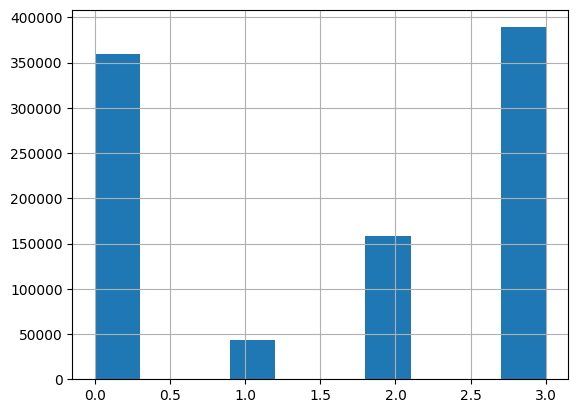

In [21]:
df_cluster['cluster'].hist()

In [22]:
clusters = df_cluster['cluster'].unique()

comparisons = {}
for cluster in df_cluster['cluster'].unique():
    codes = df_cluster[df_cluster['cluster']==cluster].groupby(['okpd_code']).count()['subject']
    comparisons[cluster] = codes.index

comparisons

{3: Index(['41.2', '42.1', '43.1', '43.3'], dtype='object', name='okpd_code'),
 1: Index(['41.2', '42.1', '43.1', '43.3'], dtype='object', name='okpd_code'),
 0: Index(['42.2', '42.9', '43.2', '43.9'], dtype='object', name='okpd_code'),
 2: Index(['41.1', '71.1'], dtype='object', name='okpd_code')}

In [23]:
def get_group(x):
    for key, value in comparisons.items():
        if x in value:            
            return key
    return 0

groups = {1:{'code':['43.1', '43.2', '43.3', '43.9'], 'name':'Строительно-монтажные работы'},
               2:{'code': ['41.1', '71.1'], 'name':'Проектно-изыскательские работы'},
               3:{'code': ['43.22'], 'name':'Подключение коммуникаций'},
               4:{'code': ['43.9', '42.9', '42.2', '43.2'], 'name':'Строительный надзор'},
              }
def get_cluster_name(x):
    return groups[x]['name']

df_cluster.groupby(['group', 'cluster', 'okpd_code'])['subject'].count()

group                           cluster  okpd_code
Подключение коммуникаций        0        43.2         162031
Проектно-изыскательские работы  2        41.1           7388
                                         71.1         151041
Строительно-монтажные работы    1        41.2             39
                                         42.1          42576
                                         43.1            104
                                         43.3            133
                                3        41.2         107530
                                         42.1         156589
                                         43.1          18216
                                         43.3         106646
Строительный надзор             0        42.2          30374
                                         42.9          58147
                                         43.9         108933
Name: subject, dtype: int64

In [24]:
df_cluster.to_csv(r"C:\Users\Admin\Jupyter\zakupki\dataset_cluster.csv", sep=';', index=False)

# Классификация контрактов

In [25]:
X = df_cluster['subject']
y = df_cluster['cluster']

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)

(683817,) (170955,)


In [42]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

### SGDClassifier

In [28]:
sgd_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('sgd_clf', SGDClassifier(random_state=42))])
sgd_ppl_clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('sgd_clf', SGDClassifier(random_state=42))])

In [29]:
predicted_sgd = sgd_ppl_clf.predict(X_test)
print(metrics.classification_report(predicted_sgd, y_test))

              precision    recall  f1-score   support

           0       0.79      0.85      0.82     60371
           1       0.92      0.92      0.92      7640
           2       0.92      0.96      0.94     27392
           3       0.88      0.81      0.85     75552

    accuracy                           0.85    170955
   macro avg       0.88      0.88      0.88    170955
weighted avg       0.86      0.85      0.85    170955



In [30]:
confusion_matrix(predicted_sgd, y_test)

array([[51376,    20,  1485,  7490],
       [  255,  6995,   167,   223],
       [  565,    19, 26257,   551],
       [12793,   529,   749, 61481]], dtype=int64)

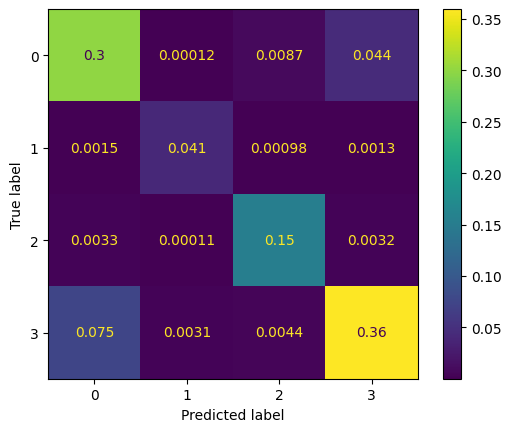

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(predicted_sgd, y_test, normalize='all')
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

In [50]:
sgd_ppl_clf['sgd_clf'].coef_

array([[-4.47157699e-01, -3.25258599e-01,  6.32478300e-03, ...,
        -4.79192765e-04,  0.00000000e+00,  6.76644797e-03],
       [ 1.40244087e-01,  5.95410097e-02,  0.00000000e+00, ...,
         9.74201820e-03,  0.00000000e+00,  0.00000000e+00],
       [-4.80073056e-02,  7.26943556e-02, -2.13768464e-02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 5.88790765e-01, -5.91444790e-02,  1.25474582e-02, ...,
        -9.74235699e-03,  0.00000000e+00, -9.66635424e-04]])

In [51]:
sgd_ppl_clf['sgd_clf'].intercept_

array([-0.23770803, -1.54531833, -0.91260765, -0.33922794])

In [38]:
from joblib import dump
dump(sgd_ppl_clf, 'sgd_ppl_clf.joblib', compress=9)

['sgd_ppl_clf.joblib']